In [38]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def calculate_curvature_circle(data, interval=1):
    curvature_list = []
    data = np.array(data)
    
    for i in range(len(data)):
        
        # 双点直线曲率为0
        if i < interval or i > len(data) - interval - 1:
            curvature_list.append(0)
            continue
        
        start, end = i - interval, i + interval + 1
        points = data[start:end:interval]
        
        if len(points) != 3:
            curvature_list.append(0)
            continue
        
        lat1, lon1 = points[0]
        lat2, lon2 = points[1]
        lat3, lon3 = points[2]

        # 映射到直角坐标系
        d1 = haversine_distance(lat1, lon1, lat2, lon2)
        d2 = haversine_distance(lat2, lon2, lat3, lon3)
        d3 = haversine_distance(lat1, lon1, lat3, lon3)

        # 三点共圆
        s = (d1 + d2 + d3) / 2  
        r = (d1 * d2 * d3) / (4 * np.sqrt(s * (s - d1) * (s - d2) * (s - d3)))

        # 曲率
        curvature = 1 / r if r != 0 else 0

        # 方向
        vector1 = (lat2 - lat1, lon2 - lon1)
        vector2 = (lat3 - lat2, lon3 - lon2)
        cross_product = vector1[0] * vector2[1] - vector1[1] * vector2[0]

        curvature *= 1 if cross_product > 0 else -1
        
        curvature_list.append(curvature)
    
    # 头尾平滑化 （这个有待商榷） TODO：把这个删了怎么样？
    curvature_list[0:interval] = [curvature_list[interval]] * interval
    curvature_list[-interval:] = [curvature_list[-interval-1]] * interval
    
    max_curvature = max(abs(c) for c in curvature_list) # 认为顺时针和逆时针弯折没有区别，但计算平均曲率时候有
    
    return np.average(curvature_list), abs(max_curvature)

# 展示路径形状
def show_road(test_point):
    longitudes, latitudes = zip(*test_point)

    plt.figure(figsize=(8, 6))
    plt.plot(longitudes, latitudes, marker='o', linestyle='-', color='b')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Connected Points Plot')
    plt.grid(True)
    plt.show()


In [3]:
all_roads = pd.read_csv('./data/road.csv')
average_curvatures = []
maximum_curvatures = []
for test_id in range(0,len(all_roads)):
    test_point = eval(all_roads.loc[all_roads['id'] == test_id, 'coordinates'].values[0])
    # show_road(test_point) #展示路径形状
    ave_curvature, max_curvature = calculate_curvature_circle(test_point)
    average_curvatures.append(ave_curvature)
    maximum_curvatures.append(max_curvature)
    
all_roads['average_curvature'] = average_curvatures  
all_roads['maximum_curvature'] = maximum_curvatures  

In [4]:
columns_to_drop = ['type', 'geometry', 'maxspeed', 'coordinates']

existing_columns_to_drop = [col for col in columns_to_drop if col in all_roads.columns]

if existing_columns_to_drop:
    all_roads.drop(columns=existing_columns_to_drop, inplace=True)
else:
    print("没有需要删除的列")

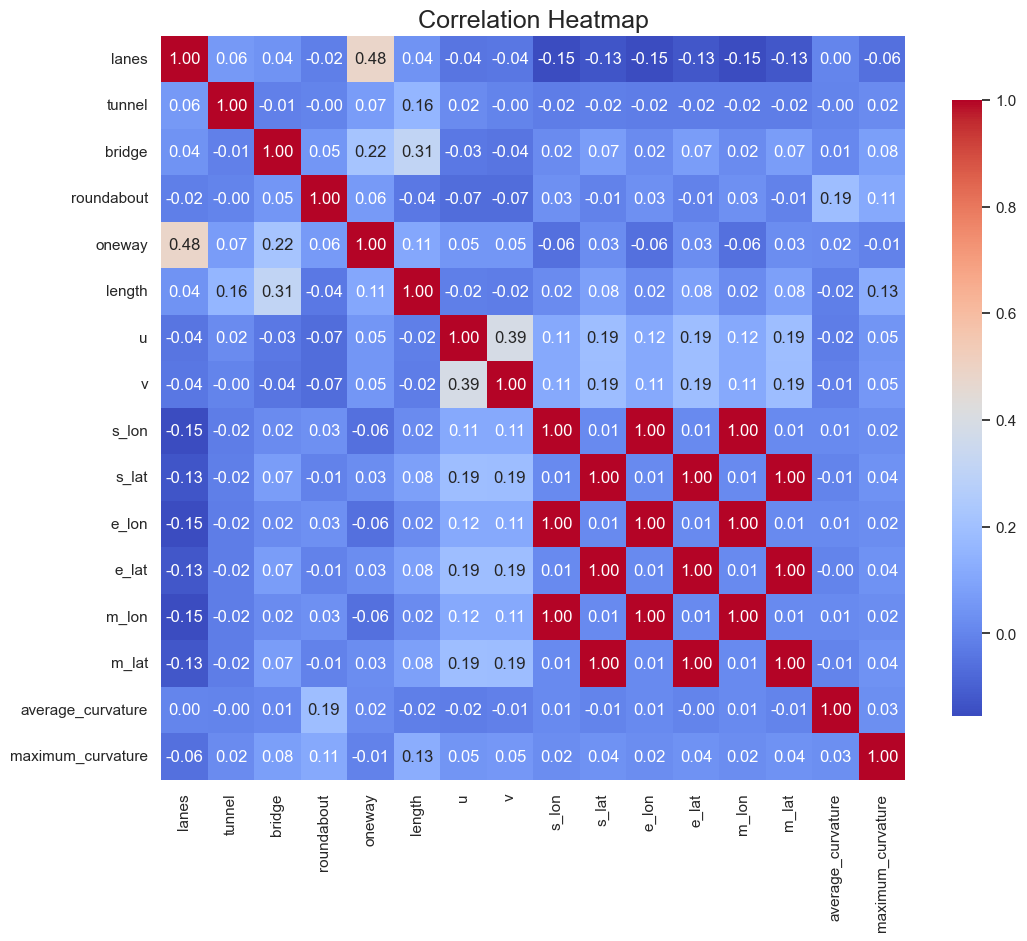

In [5]:
columns_to_correlate = ['lanes', 'tunnel', 'bridge', 'roundabout', 'oneway', 
                         'length', 'u', 'v', 's_lon', 's_lat', 'e_lon', 
                         'e_lat', 'm_lon', 'm_lat', 'average_curvature', 
                         'maximum_curvature']

correlation_matrix = all_roads[columns_to_correlate].corr()

sns.set_theme(style='white')
# 绘制热力图
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [30]:
operation_df = all_roads.copy()

#将u,v归一化
operation_df['u_normalized'] = (operation_df['u'] - operation_df['u'].min()) / (operation_df['u'].max() - operation_df['u'].min())
operation_df['v_normalized'] = (operation_df['v'] - operation_df['v'].min()) / (operation_df['v'].max() - operation_df['v'].min())
operation_df['s_lon'] = (operation_df['s_lon'] - operation_df['s_lon'].min()) / (operation_df['s_lon'].max() - operation_df['s_lon'].min())
operation_df['e_lon'] = (operation_df['e_lon'] - operation_df['e_lon'].min()) / (operation_df['e_lon'].max() - operation_df['e_lon'].min())
operation_df['s_lat'] = (operation_df['s_lat'] - operation_df['s_lat'].min()) / (operation_df['s_lat'].max() - operation_df['s_lat'].min())
operation_df['e_lat'] = (operation_df['e_lat'] - operation_df['e_lat'].min()) / (operation_df['e_lat'].max() - operation_df['e_lat'].min())


In [31]:
fill_data_basic = operation_df[operation_df['highway'].isna()]
train_data_basic = operation_df[~operation_df['highway'].isna()]

features = ['lanes', 'tunnel', 'bridge', 'roundabout', 'oneway', 
            'length', 's_lon', 's_lat', 'e_lon', 'e_lat', 
            'm_lon', 'm_lat', 'average_curvature', 'maximum_curvature', 
            'u_normalized', 'v_normalized'
            ]
target = 'highway'

seed = 114514
X = train_data_basic[features]
y = train_data_basic[target]
X_fill = fill_data_basic[features]
Y_fill_id = fill_data_basic['id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [32]:

models = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=None, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, random_state=seed)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=23, learning_rate=0.06, objective='multi:softmax', eval_metric='mlogloss', gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.01, reg_lambda=1, n_jobs=-1, random_state=seed)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=20, learning_rate=0.05, num_leaves=31, objective='multiclass', metric='multi_logloss', subsample=0.8, colsample_bytree=0.8, reg_alpha=0.01, reg_lambda=1, n_jobs=-1, verbosity=-1, random_state=seed)),
    ('et', ExtraTreesClassifier(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, random_state=seed)),
]


voting_clf = VotingClassifier(estimators=models, voting='soft', weights=[2, 1, 3, 4.5])  # 使用 soft 投票
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=300,
                                                     random_state=114514)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=0.15,
                                            grow_...
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...)),
                             ('lgb',
                              LGBMClassifier(colsample_bytree=0.8,
                                             learning_rate=0.05, max_depth=20,
                                             metric='multi_logloss', n_jobs=-1,
                                             objective='multiclass',
                                             random_state=114514,
                                             reg_alpha=0.01, reg_lambda=1,
                                             subsample=0.8, verbosity=-1)),
                             ('et',
                              ExtraTreesClassifier(n_estimators=200,
                                                   random_state=114514))],
                 voting='soft', weights=[2, 1, 3, 4.5])

{0.0: {1.0: 100.0}, 1.0: {1.0: 68.04123711340206, 2.0: 4.123711340206185, 3.0: 1.0309278350515463, 5.0: 2.0618556701030926, 8.0: 22.68041237113402, 9.0: 2.0618556701030926}, 2.0: {1.0: 0.5692599620493358, 2.0: 56.92599620493358, 3.0: 9.392789373814042, 4.0: 14.61100569259962, 5.0: 5.88235294117647, 6.0: 9.297912713472485, 8.0: 0.9487666034155597, 9.0: 1.3282732447817838, 10.0: 0.09487666034155598, 12.0: 0.9487666034155597}, 3.0: {1.0: 0.1551590380139643, 2.0: 7.757951900698215, 3.0: 58.41737781225756, 4.0: 12.95577967416602, 5.0: 4.654771140418929, 6.0: 12.95577967416602, 8.0: 0.7757951900698216, 9.0: 0.6206361520558572, 10.0: 1.2412723041117144, 11.0: 0.07757951900698215, 12.0: 0.3878975950349108}, 4.0: {1.0: 0.033355570380253496, 2.0: 4.903268845897265, 3.0: 5.303535690460307, 4.0: 74.11607738492329, 5.0: 3.502334889926618, 6.0: 10.940627084723149, 8.0: 0.033355570380253496, 9.0: 0.23348899266177453, 10.0: 0.06671114076050699, 11.0: 0.06671114076050699, 12.0: 0.8005336891260841}, 5.0

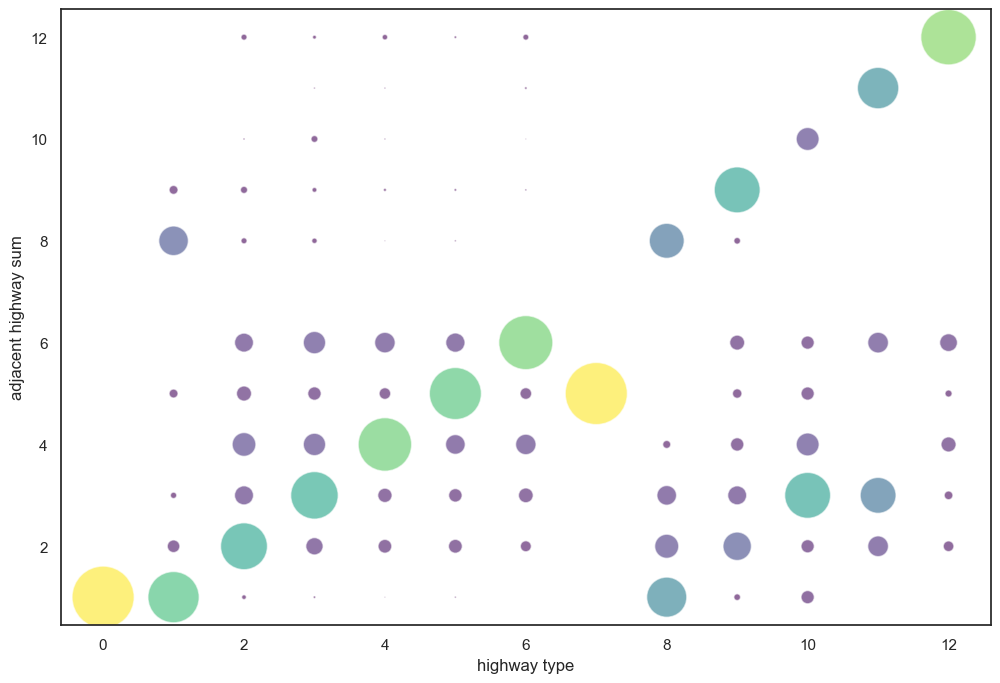

In [33]:
roads = pd.read_csv('./data/road.csv')
fill_data_basic = roads[roads['highway'].isna()]
full_data_basic = roads[~roads['highway'].isna()]


with open('./data/road_neighbor_cd.json') as f:
    data = json.load(f)

fill_data_adjcent = {}
full_data_adjacent = {}
for key, value in data.items():
    key = int(key)
    if key in full_data_basic['id']:
        full_data_adjacent[key] = value
    else:
        fill_data_adjcent[key] = value
        
adj_map = {}
for key, values in full_data_adjacent.items():
    highway_type =  full_data_basic.loc[full_data_basic['id'] == key, 'highway'].values[0]
    value_list = []
    temp_map = {}
    for value in values:
        if value in full_data_basic['id'].values:
            value_list.append(full_data_basic.loc[full_data_basic['id'] == value, 'highway'].values[0])
    for value in value_list:
        temp_map[value] = temp_map.get(value, 0) + 1
    
    for key2, value2 in temp_map.items():
        if key2 not in adj_map:
            adj_map[key2] = {}
        adj_map[key2][highway_type] = adj_map[key2].get(highway_type, 0) + value2
sorted_map = {k: dict(sorted(v.items())) for k, v in sorted(adj_map.items())}

for key, value in sorted_map.items():
    list_of_values = []
    for key2, value2 in value.items():
        list_of_values.append(value2)
    for key2, value2 in value.items():
        value[key2] = value2 / sum(list_of_values) * 100
print(sorted_map)

plt.figure(figsize=(12, 8))

# 可视化
x = []
y = []
sizes = []

for key, sub_dict in sorted_map.items():
    for sub_key, count in sub_dict.items():
        x.append(key)
        y.append(sub_key)
        sizes.append(count)  

plt.scatter(x, y, s=np.array(sizes)*20, c=sizes, cmap='viridis', alpha=0.6, edgecolors='w')
plt.xlabel('highway type')
plt.ylabel('adjacent highway sum')

plt.show()

# 显示每个 highway 类型对应的邻接 highway 类型
adj_list = []
for key, values in data.items():
    value_list = []
    for value in values:
        if value in full_data_basic['id'].values:
            value_list.append(int(full_data_basic.loc[full_data_basic['id'] == value, 'highway'].values[0]))
        
    adj_list.append(value_list)
    

In [34]:

def calculate_road_type_probability(road_id):
    adjacent_types = adj_list[road_id]
    
    probability_distribution = {}

    for typ in adjacent_types:
        # 获取相应类型的频率并转换为概率
        for road_type, freq in sorted_map.get(typ, {}).items():
            probability_distribution[road_type] = probability_distribution.get(road_type, 0) + freq
            
    total = sum(probability_distribution.values())
    if total > 0:
        for road_type in probability_distribution:
            probability_distribution[road_type] /= total 
            
    sorted_distribution = {key: probability_distribution.get(key, 0) for key in range(0, 13)}


    return np.array(list(sorted_distribution.values()))

def get_predicted_road_type(X_test, alpha):
    adja_proba_list = []

    for id in X_test.index:
        adja_proba = calculate_road_type_probability(id)
        adja_proba_list.append(adja_proba)
        

    adja_proba_array = np.array(adja_proba_list)
    vote_proba = voting_clf.predict_proba(X_test)
    
    weighted_average = alpha * vote_proba + (1 - alpha) * adja_proba_array
    predicted_classes = np.argmax(weighted_average, axis=1)
    
    return predicted_classes



In [43]:
alphas = np.arange(0, 1.01, 0.02)
accuracies = []
f1_scores = []
precisions = []
recalls = []
rmses = []
# 加权平均
for alpha in alphas:
    
    y_pred = get_predicted_road_type(X_test, alpha)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse / 10)

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    rmses.append(rmse)

c:\Users\86138\anaconda3\envs\dataMining\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


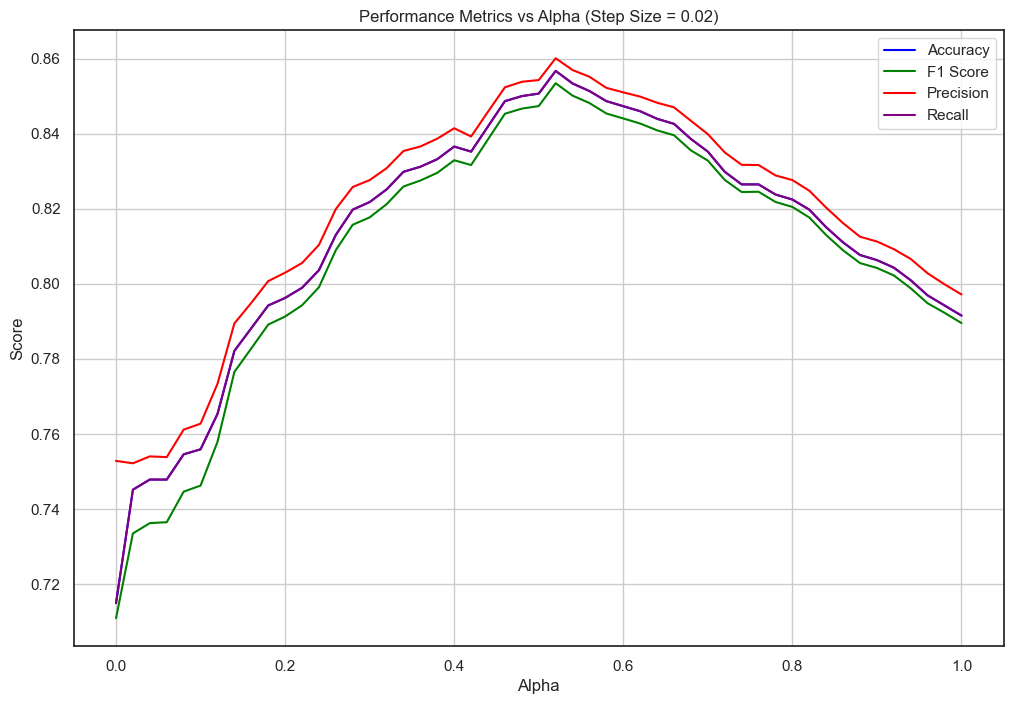

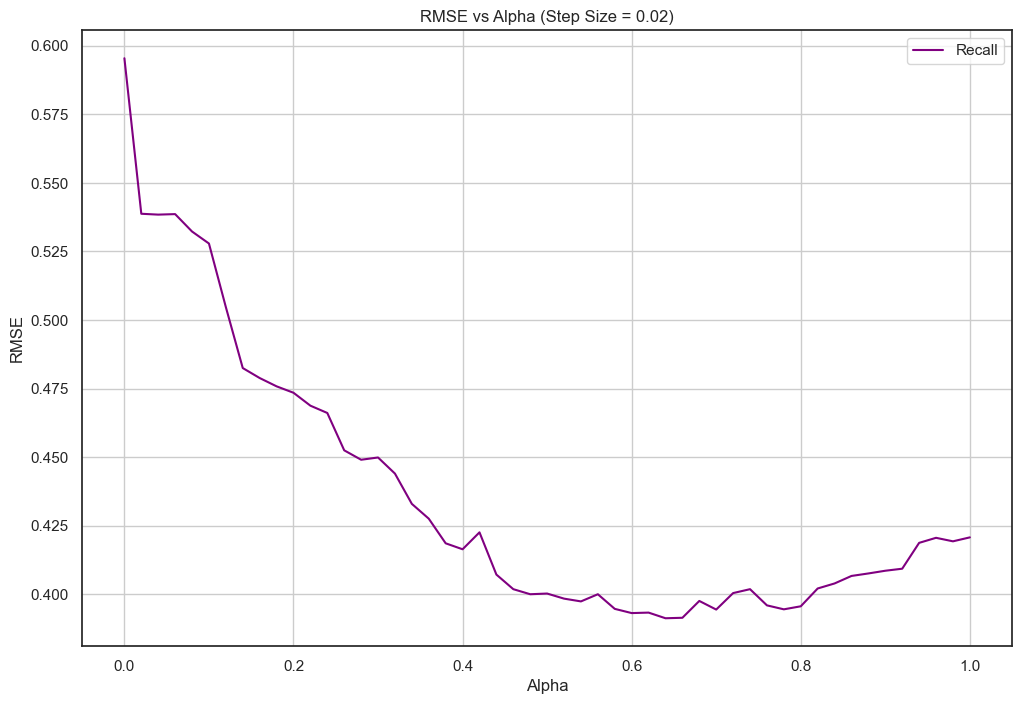

Best Alpha: 0.52
Best Accuracy: 0.8567585743106927
Best F1 Score: 0.8534623580222409
Best Precision: 0.8601265873284054
Best Recall: 0.8567585743106927

Mini RMSE -> Alpha: 0.64
Mini RMSE: 0.39131458131117275


In [47]:

plt.figure(figsize=(12, 8))

# Plot metrics
plt.plot(alphas, accuracies, label='Accuracy', color='blue')
plt.plot(alphas, f1_scores, label='F1 Score', color='green')
plt.plot(alphas, precisions, label='Precision', color='red')
plt.plot(alphas, recalls, label='Recall', color='purple')

# Annotate maximum values
metrics = {
    'Accuracy': (accuracies, 'blue'),
    'F1 Score': (f1_scores, 'green'),
    'Precision': (precisions, 'red'),
    'Recall': (recalls, 'purple'),
}

plt.title('Performance Metrics vs Alpha (Step Size = 0.02)')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(alphas, rmses, label='Recall', color='purple')
metrics = {
    'RMSE': (rmses, 'purple'),
}
plt.title('RMSE vs Alpha (Step Size = 0.02)')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


print('Best Alpha:', (alphas[np.argmax(accuracies)] + alphas[np.argmax(f1_scores)] + alphas[np.argmax(precisions)] + alphas[np.argmax(recalls)])/4)
print('Best Accuracy:', np.max(accuracies))
print('Best F1 Score:', np.max(f1_scores))
print('Best Precision:', np.max(precisions))
print('Best Recall:', np.max(recalls))

print('\nMini RMSE -> Alpha:', alphas[np.argmin(rmses)])
print('Mini RMSE:', np.min(rmses))



In [37]:
y_fill = get_predicted_road_type(X_fill, 0.52)

res_id = pd.DataFrame(Y_fill_id, columns=['id'])

res_id['predicted_type'] = y_fill

res_id.to_csv('./results/submission_task2.csv', index=False)

res_id.head()

,id,predicted_type
8,8,3
14,14,6
15,15,5
17,17,3
19,19,6
